In [1]:
import os
import glob
import gc
from dotenv import load_dotenv
import fnmatch
import ast
from collections import Counter
import numpy as np
import pandas as pd
import dask.array as da
from dask_ml.impute import SimpleImputer as si
from dask_ml.preprocessing import StandardScaler as ss
# from dask_ml.decomposition import PCA as PCA

from scipy.signal import find_peaks
from scipy.linalg import norm
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from itertools import combinations

from utils.preproc import load_parcellation, get_roi_and_network_ids
from utils.coflt import read_coflt_data, reconstruct_matrix, extract_upper_triangle, to_matrix, flatten_3D

from matplotlib import image as img
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import seaborn as sns

In [2]:
load_dotenv()
base_dir = os.getenv("BASE_DIR")
# base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, "data")
parcellation_dir = os.path.join(data_dir, "fmriprep", "yan_parcellations")
coft_output_dir = os.path.join(base_dir, "output", "cofluctuation_LOO")
eFC_ntw_output_dir = os.path.join(base_dir, "output", "eFC_network")
eFC_roi_ntw_output_dir = os.path.join(base_dir, "output", "eFC_roi_network")
# plot_output_dir = os.path.join(base_dir, "output", "plots")
# os.makedirs(plot_output_dir, exist_ok=True)

In [3]:
n_parcel = 400

In [5]:
affair_eFC_ntw_file = os.path.join(eFC_ntw_output_dir, f"{n_parcel}parcel", "affair_eFC.npy")
affair_eFC_ntw = np.load(affair_eFC_ntw_file)
affair_eFC_ntw.shape

(136, 136)

In [17]:
paranoia_eFC_ntw_file = os.path.join(eFC_ntw_output_dir, f"{n_parcel}parcel", "paranoia_eFC.npy")
paranoia_eFC_ntw = np.load(paranoia_eFC_ntw_file)
paranoia_eFC_ntw.shape

(136, 136)

In [18]:
diagonals = np.diagonal(paranoia_eFC_ntw)
diagonals

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [4]:
affair_event_files = glob.glob(os.path.join(eFC_ntw_output_dir, f"{n_parcel}parcel", "affair_eFC_event*.npy"))
affair_event_files.sort()

In [5]:
f = "/om/user/yibei/prettymouth/output/eFC_network/400parcel/affair_eFC_event02.npy"
test = np.load(f)
test.shape

(136, 136)

In [6]:
for f in affair_event_files:
    data = np.load(f)
    dia = np.diagonal(data)
    # check if the diagonal all equal to 1
    if np.all(dia == 1):
        continue
    else:
        print(f)
        print(dia)

/om/user/yibei/prettymouth/output/eFC_network/400parcel/affair_eFC_event01.npy
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99998878 1.         1.
 1.         1.         1.         1.         0.99005217 0.89046486
 0.99966752 0.99989214 1.         0.99947354 0.99938694 1.
 0.95358792 0.99075023 0.99982777 0.99949693 0.99997723 1.
 1.         0.81610253 0.99974821 1.         0.99981322 0.99873558
 0.99985599 1.         0.97464655 0.98814208 0.99989307 0.99984746
 1.         0.99999834 1.         0.99525889 0.99921196 0.9993053
 0.92197189 0.99816567 1.         0.99813551 0.99950795 0.99903247
 0.99904641 0.9999621  1.         0.99991436 1.         1.
 1.         1.         1.         0.99985839 0.99998247 1.
 1.         1.         1.         1.         0.99999658 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99999906 1.
 1.         1.         1.         1.         1.         

In [8]:
# get the diagnals of affair_eFC_ntw
diagonals = np.diagonal(affair_eFC_ntw)

In [9]:
diagonals

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

<AxesSubplot:>

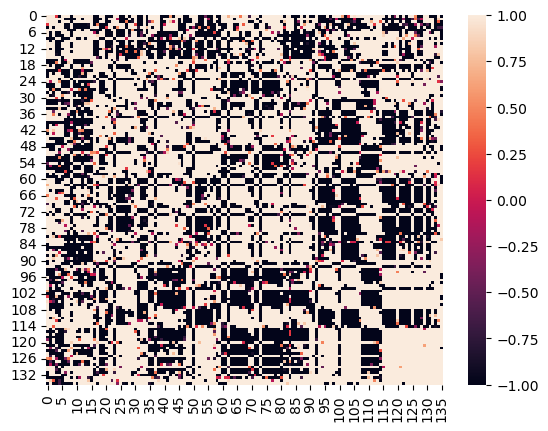

In [7]:
sns.heatmap(affair_eFC_ntw)

In [6]:
affair_coflt = read_coflt_data(n_parcel, "affair", coft_output_dir)
mean_affair_coflt = np.nanmean(affair_coflt, axis=0)

coflt shape: (19, 400, 400, 475)


In [5]:
# Load parcellation data
parcellation = np.load(os.path.join(parcellation_dir, f"yan_kong17_{n_parcel}parcels.npz"))
_, _, _, networknames_idx_dict = get_roi_and_network_ids(parcellation, n_parcel)


Number of ROIs: 44
Number of ROIs separated by networks: 126
Number of ROIs separated by hemispheres: 227
Number of networks: 17


In [7]:
matrix = mean_affair_coflt
name_idx_dict = networknames_idx_dict

In [8]:
_, _, n_TRs = matrix.shape
n_keys = len(name_idx_dict)
# initialize an empty 2D matrix to save RMS
rms_matrix = np.zeros((n_keys, n_TRs))
new_matrix = np.zeros((n_keys, n_keys, n_TRs))

for i, k1 in enumerate(name_idx_dict.keys()):
    print(f"Processing {k1}...")
    idx = name_idx_dict[k1]
    idx1_grid, idx2_grid = np.meshgrid(idx, idx, indexing='ij')
    print("Index grid shape:", idx1_grid.shape, idx2_grid.shape)
    sliced_matrix = matrix[idx1_grid, idx2_grid, :]
    print("Sliced matrix shape:", sliced_matrix.shape) 
    # flatten sliced matrix to 2D
    flattened_sliced_matrix = flatten_3D(sliced_matrix)
    print("Flattened sliced matrix shape:", flattened_sliced_matrix.shape)
    # calculate RMS of flattened sliced matrix
    rms = norm(flattened_sliced_matrix, axis=0) / np.sqrt(flattened_sliced_matrix.shape[0])
    print("RMS shape:", rms.shape)
    rms_matrix[i, :] = rms

Processing Aud...
Index grid shape: (16, 16) (16, 16)
Sliced matrix shape: (16, 16, 475)
The shape of flattened is (120, 475)
Flattened sliced matrix shape: (120, 475)
RMS shape: (475,)
Processing ContA...
Index grid shape: (21, 21) (21, 21)
Sliced matrix shape: (21, 21, 475)
The shape of flattened is (210, 475)
Flattened sliced matrix shape: (210, 475)
RMS shape: (475,)
Processing ContB...
Index grid shape: (33, 33) (33, 33)
Sliced matrix shape: (33, 33, 475)
The shape of flattened is (528, 475)
Flattened sliced matrix shape: (528, 475)
RMS shape: (475,)
Processing ContC...
Index grid shape: (20, 20) (20, 20)
Sliced matrix shape: (20, 20, 475)
The shape of flattened is (190, 475)
Flattened sliced matrix shape: (190, 475)
RMS shape: (475,)
Processing DefaultA...
Index grid shape: (36, 36) (36, 36)
Sliced matrix shape: (36, 36, 475)
The shape of flattened is (630, 475)
Flattened sliced matrix shape: (630, 475)
RMS shape: (475,)
Processing DefaultB...
Index grid shape: (32, 32) (32, 32)


In [9]:
rms_matrix.shape

(17, 475)

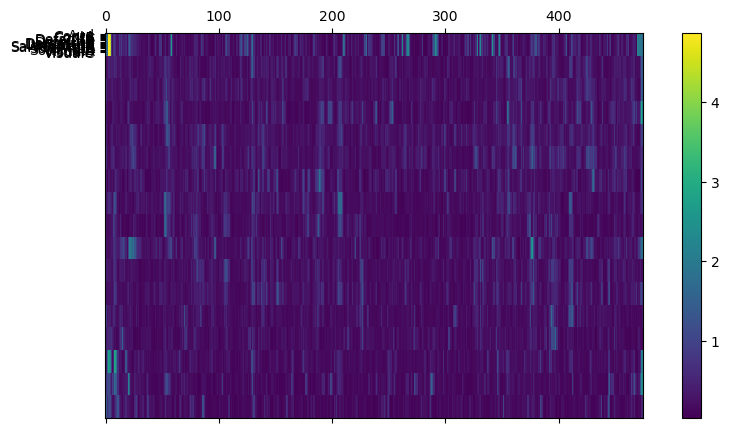

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.matshow(np.repeat(rms_matrix, 20, axis=0))  # 'im' holds the mappable object
# add colorbar
fig.colorbar(im)
# set ticks, y ticks are name_idx_dict.keys()
# ax.set_xticks(np.arange(len(name_idx_dict)))
ax.set_yticks(np.arange(len(name_idx_dict)))
# ax.set_xticklabels(name_idx_dict.keys())
ax.set_yticklabels(name_idx_dict.keys())
plt.show()

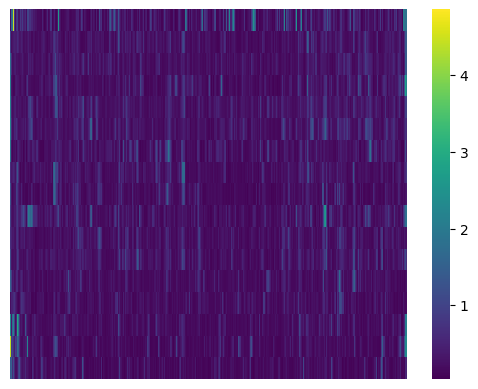

In [32]:
# plot heatmap
sns.heatmap(rms_matrix, xticklabels=False, yticklabels=False, cmap='viridis')
plt.show()

In [27]:
def clustered_heatmap(matrix):
    # Compute the linkage matrix for rows
    row_linkage = linkage(matrix, method='average')
    
    # Compute the linkage matrix for columns
    col_linkage = linkage(matrix.T, method='average')
    
    # Reorder rows and columns based on hierarchy
    row_order = leaves_list(row_linkage)
    col_order = leaves_list(col_linkage)
    ordered_matrix = matrix[row_order][:, col_order]
    
    # Plot the heatmap
    sns.heatmap(ordered_matrix, xticklabels=False, yticklabels=False, cmap='viridis')
    plt.show()

In [24]:
def clustered_heatmap_with_dendrogram(matrix):
    # Compute the linkage matrix for rows
    row_linkage = linkage(matrix, method='average')
    
    # Compute the linkage matrix for columns
    col_linkage = linkage(matrix.T, method='average')
    
    # Reorder rows and columns based on hierarchy
    row_order = leaves_list(row_linkage)
    col_order = leaves_list(col_linkage)
    ordered_matrix = matrix[row_order][:, col_order]
    
    # Create a figure with specific layout
    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_axes([0.05, 0.1, 0.1, 0.6])  # for the row dendrogram
    ax2 = fig.add_axes([0.16, 0.71, 0.5, 0.2])  # for the column dendrogram
    ax3 = fig.add_axes([0.16, 0.1, 0.5, 0.6])   # for the heatmap
    cax = fig.add_axes([0.68, 0.1, 0.02, 0.6])  # for the colorbar
    
    # Plot the dendrograms
    row_dendrogram = dendrogram(row_linkage, ax=ax1, orientation='left', no_labels=True)
    col_dendrogram = dendrogram(row_linkage, ax=ax2, orientation='top', no_labels=True)
    
    # Turn axes visibility off for dendrograms
    ax1.axis('off')
    ax2.axis('off')
    
    # Plot the heatmap
    sns.heatmap(ordered_matrix, ax=ax3, xticklabels=False, yticklabels=False, cmap='viridis', cbar_ax=cax)
    
    plt.show()

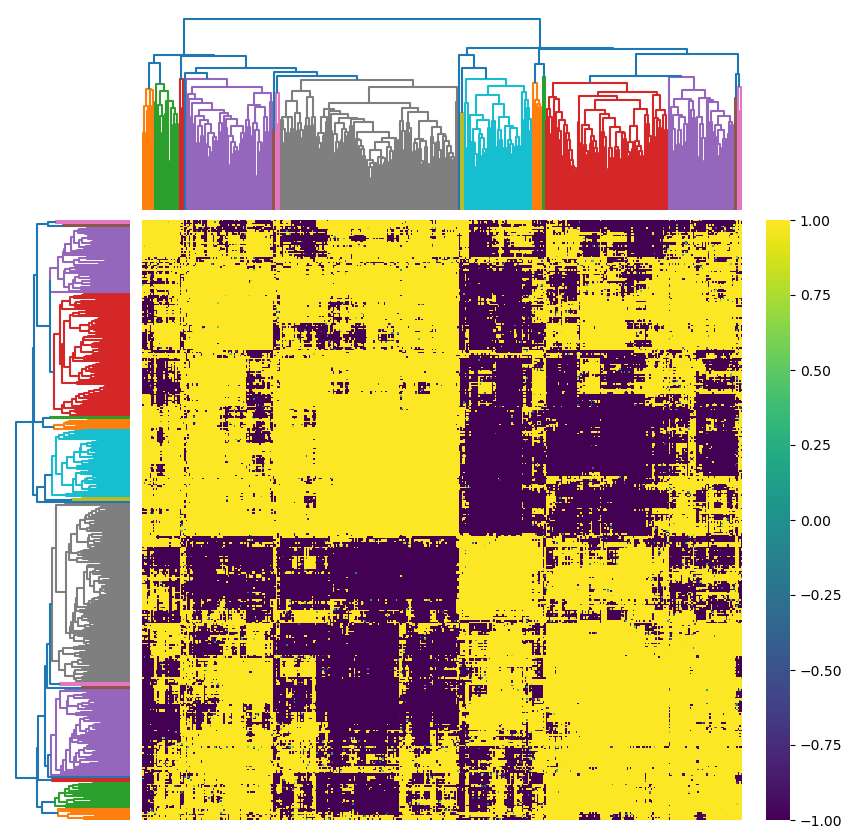

In [25]:
matrix = test_data[:400, :400] # Using a smaller matrix for demonstration
clustered_heatmap_with_dendrogram(matrix)

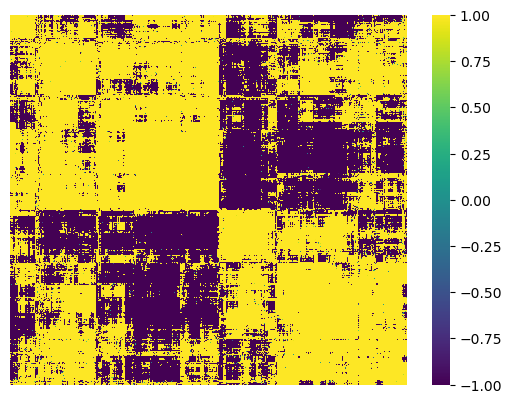

In [28]:
clustered_heatmap(matrix)

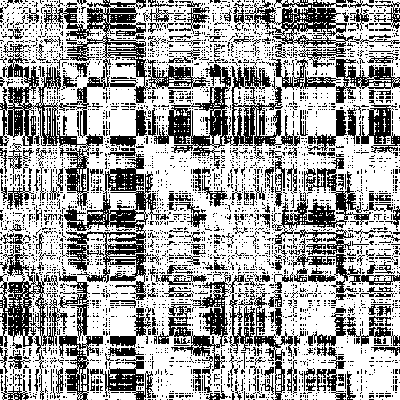

In [29]:
from PIL import Image

# Normalize the matrix to 0-255
normalized_matrix = ((matrix - matrix.min()) * (1/(matrix.max() - matrix.min()) * 255)).astype('uint8')

# Convert to image and save
img = Image.fromarray(normalized_matrix)
img

In [30]:
img = Image.fromarray(test_data)
img

: 

: 

In [43]:
def index_to_node_pair(k, n_parcel):
    # Total number of elements before the ith row in the flattened matrix
    sum_before_i = 0
    for i in range(n_parcel - 1):
        sum_before_i += n_parcel - 1 - i
        if sum_before_i > k:
            sum_before_i -= n_parcel - 1 - i  # remove the count of the current row
            break
    j = (k - sum_before_i) + i + 1
    return (i, j)

def index_to_edge_pair(i, j, n_parcel):
    # Using the previously defined function
    edge1 = index_to_node_pair(i, n_parcel)
    edge2 = index_to_node_pair(j, n_parcel)
    return (edge1, edge2)

In [5]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from itertools import combinations

# Sample data
# whole_matrix = np.random.rand(79800, 79800)
# segment_matrices = [np.random.rand(79800, 79800) for _ in range(22)]

def mantel_test(matrix1, matrix2, perms=10000):
    """
    Computes the Mantel test for two matrices and returns the correlation and p-value.
    """
    distances1 = pdist(matrix1)
    distances2 = pdist(matrix2)
    
    observed_corr = pearsonr(distances1, distances2)[0]
    
    permuted_corrs = []
    for _ in range(perms):
        permuted = np.random.permutation(distances2)
        permuted_corrs.append(pearsonr(distances1, permuted)[0])
    
    p_value = (np.sum(np.abs(permuted_corrs) >= np.abs(observed_corr)) + 1) / (perms + 1)
    
    return observed_corr, p_value

# Step 1: PCA on the whole matrix
pca = PCA(n_components=0.95)  # retain 95% variance
pca.fit(whole_matrix)
transformed_whole = pca.transform(whole_matrix)

# Step 2: Apply PCA transformation to each segment matrix
transformed_segments = [pca.transform(matrix) for matrix in segment_matrices]

# Step 3: Compute pairwise Mantel test
similarity_matrix = np.zeros((22, 22))
p_value_matrix = np.zeros((22, 22))

for i, j in combinations(range(22), 2):
    correlation, p_value = mantel_test(transformed_segments[i], transformed_segments[j])
    similarity_matrix[i, j] = correlation
    similarity_matrix[j, i] = correlation
    p_value_matrix[i, j] = p_value
    p_value_matrix[j, i] = p_value

print(similarity_matrix)
print(p_value_matrix)


In [13]:
affair_eFC.shape

(4950, 4950)

In [44]:
print(index_to_edge_pair(0, 0, 400))  # Expected output: ((0, 1), (0, 2))
print(index_to_edge_pair(0, 6, 5))  # Expected output: ((0, 2), (398, 399))

((0, 1), (0, 1))
((0, 1), (1, 4))


In [6]:
# get 2D from 3D
def flatten_3D(data):
    n_edge = data.shape[0]
    n_TR = data.shape[2]
    # Extract upper triangle indices
    i_upper, j_upper = np.triu_indices(data.shape[0], k=1)

    # Convert the 3D array into a 2D array with shape (400*399/2, n_TR)
    flattened = data[i_upper, j_upper]
    print(f"The shape of flattened is {flattened.shape}")
    assert flattened.shape[0] == n_edge * (n_edge - 1) / 2
    assert flattened.shape[1] == n_TR
    return flattened

In [9]:
def get_eFC(data):
    # Compute standard deviations for each product time series
    std_devs = np.std(data, axis=1)

    # Element-wise multiplication between all pairs of time series
    elementwise_products = data[:, None, :] * data[None, :, :]
    
    # Sum over the time axis
    summed_products = np.sum(elementwise_products, axis=2)
    
    # Normalize by the square root of the product of standard deviations
    norm_factors = np.sqrt(std_devs[:, None] * std_devs[None, :])
    eFC_matrix = summed_products / norm_factors
    
    # Ensure values are bounded within [-1, 1]
    eFC_matrix = np.clip(eFC_matrix, -1, 1)
    
    print(f"The shape of eFC is {eFC_matrix.shape}")
    return eFC_matrix


In [10]:
def get_eFC_chunked(data, chunk_size=1000):
    n_series = data.shape[0]
    std_devs = np.std(data, axis=1)

    # Initialize the eFC matrix
    eFC_matrix = np.zeros((n_series, n_series))
    
    # Chunk-wise computation
    for i in range(0, n_series, chunk_size):
        end_i = min(i + chunk_size, n_series)
        
        for j in range(0, n_series, chunk_size):
            end_j = min(j + chunk_size, n_series)
            
            chunk_product = data[i:end_i, None, :] * data[None, j:end_j, :]
            chunk_sum = np.sum(chunk_product, axis=2)
            norm_factors = np.sqrt(std_devs[i:end_i, None] * std_devs[None, j:end_j])
            
            eFC_matrix[i:end_i, j:end_j] = chunk_sum / norm_factors
    
    # Ensure values are bounded within [-1, 1]
    eFC_matrix = np.clip(eFC_matrix, -1, 1)
    
    print(f"The shape of eFC is {eFC_matrix.shape}")
    return eFC_matrix

In [12]:
# Sample data
flattened_affair_sample = flattened_affair[:1000, :]

# Compute using the original function
eFC_original = get_eFC(flattened_affair_sample)

# Compute using the chunked function
eFC_chunked = get_eFC_chunked(flattened_affair_sample, chunk_size=100)

# Check if the results match closely
difference = np.abs(eFC_original - eFC_chunked)
print(f"Maximum difference: {difference.max()}")

The shape of eFC is (1000, 1000)
The shape of eFC is (1000, 1000)
Maximum difference: 0.0


In [11]:
whole_matrix = np.load(os.path.join(eFC_output_dir, f"{n_parcel}parcel", "affair_eFC.npy"), mmap_mode='r')

In [5]:
flattened_matrix = np.load("test_data.npy").reshape(-1,1)
flattened_matrix.shape

(3183980100, 1)

In [12]:
from sklearn.decomposition import TruncatedSVD

# Using TruncatedSVD to approximate PCA
svd = TruncatedSVD(n_components=500)  # Start with a reasonable guess
data_svd = svd.fit_transform(whole_matrix)

# Check explained variance ratio
explained_variance = svd.explained_variance_ratio_.sum()

print(f"Explained variance with {svd.n_components} components: {explained_variance:.2f}")

In [9]:
# whole_matrix.tofile(os.path.join(eFC_output_dir, f"{n_parcel}parcel", "affair_eFC.dat"))

In [10]:
whole_matrix.shape

(79800, 79800)

In [13]:
# get the quantile of the matrix
q = 0.45
quantile_value = np.quantile(whole_matrix, q)
print(f"The {q}-quantile value is {quantile_value}")

2023-10-05 12:24:40,284 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2023-10-05 12:24:40,284 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/home/yibei/.conda/envs/prettymouth/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/yibei/.conda/envs/prettymouth/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yibei/.conda/envs/prettymouth/lib/python3.10/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/home/yibei/.conda/envs/prettymouth/lib/python3.10/site-packages/distributed/nanny.py", line 1007, in _run
    asyncio_run(run(), loop_factory=get_loop_factory())
  File "/home/yibei/.conda/envs/prettymouth/lib/python3.10/site-packages/distributed/compatibility.py", line 236, 

KeyboardInterrupt: 

In [15]:
sample = whole_matrix[:100, :100]

In [29]:
sample[10].shape

(100,)

In [7]:
mmapped_matrix = np.memmap(os.path.join(eFC_output_dir, f"{n_parcel}parcel", "affair_eFC.dat"), dtype=whole_matrix.dtype, mode='r', shape=whole_matrix.shape)


In [8]:
mmapped_matrix

memmap([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1., -1.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1., -1., ...,  1.,  1.,  1.]])

In [30]:
upper_index = np.triu_indices(whole_matrix.shape[0], k=1)

In [31]:
flattened_data = whole_matrix[upper_index]

: 

: 

In [9]:
pca = PCA(svd_solver='randomized')
pca.fit(dask_array)

: 

: 

In [5]:
affair_eFC_files = glob.glob(os.path.join(eFC_output_dir, f"{n_parcel}parcel", "affair_eFC_event*.npy"))
affair_eFC_files.sort()

In [6]:
affair_eFC_files

['/om/user/yibei/prettymouth/output/eFC/400parcel/affair_eFC_event01.npy',
 '/om/user/yibei/prettymouth/output/eFC/400parcel/affair_eFC_event02.npy',
 '/om/user/yibei/prettymouth/output/eFC/400parcel/affair_eFC_event03.npy',
 '/om/user/yibei/prettymouth/output/eFC/400parcel/affair_eFC_event04.npy',
 '/om/user/yibei/prettymouth/output/eFC/400parcel/affair_eFC_event05.npy',
 '/om/user/yibei/prettymouth/output/eFC/400parcel/affair_eFC_event06.npy',
 '/om/user/yibei/prettymouth/output/eFC/400parcel/affair_eFC_event07.npy',
 '/om/user/yibei/prettymouth/output/eFC/400parcel/affair_eFC_event08.npy',
 '/om/user/yibei/prettymouth/output/eFC/400parcel/affair_eFC_event09.npy',
 '/om/user/yibei/prettymouth/output/eFC/400parcel/affair_eFC_event10.npy',
 '/om/user/yibei/prettymouth/output/eFC/400parcel/affair_eFC_event11.npy',
 '/om/user/yibei/prettymouth/output/eFC/400parcel/affair_eFC_event12.npy',
 '/om/user/yibei/prettymouth/output/eFC/400parcel/affair_eFC_event13.npy',
 '/om/user/yibei/prettymo

In [7]:
# Step 1: PCA on the whole matrix
pca = PCA(n_components=0.95)  # retain 95% variance
pca.fit(whole_matrix)

: 

: 

In [7]:

transformed_whole = pca.transform(whole_matrix)

: 

: 

In [ ]:


# Sample data
# whole_matrix = np.random.rand(79800, 79800)
# segment_matrices = [np.random.rand(79800, 79800) for _ in range(22)]

def mantel_test(matrix1, matrix2, perms=10000):
    """
    Computes the Mantel test for two matrices and returns the correlation and p-value.
    """
    distances1 = pdist(matrix1)
    distances2 = pdist(matrix2)
    
    observed_corr = pearsonr(distances1, distances2)[0]
    
    permuted_corrs = []
    for _ in range(perms):
        permuted = np.random.permutation(distances2)
        permuted_corrs.append(pearsonr(distances1, permuted)[0])
    
    p_value = (np.sum(np.abs(permuted_corrs) >= np.abs(observed_corr)) + 1) / (perms + 1)
    
    return observed_corr, p_value

# Step 1: PCA on the whole matrix
pca = PCA(n_components=0.95)  # retain 95% variance
pca.fit(whole_matrix)
transformed_whole = pca.transform(whole_matrix)

# Step 2: Apply PCA transformation to each segment matrix
transformed_segments = [pca.transform(matrix) for matrix in segment_matrices]

# Step 3: Compute pairwise Mantel test
similarity_matrix = np.zeros((22, 22))
p_value_matrix = np.zeros((22, 22))

for i, j in combinations(range(22), 2):
    correlation, p_value = mantel_test(transformed_segments[i], transformed_segments[j])
    similarity_matrix[i, j] = correlation
    similarity_matrix[j, i] = correlation
    p_value_matrix[i, j] = p_value
    p_value_matrix[j, i] = p_value

print(similarity_matrix)
print(p_value_matrix)
